In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error

from utils.train import train, create_dataloader
from models import cVAE

### Load/Process Data:

In [2]:
batch_size = 32

train_path = 'data/Ferguson_fire_train.npy'
train_loader = create_dataloader(train_path, batch_size)

val_path = 'data/Ferguson_fire_test.npy'
val_loader = create_dataloader(val_path, batch_size, mode='val')

### Train (ConvVAE) Model:

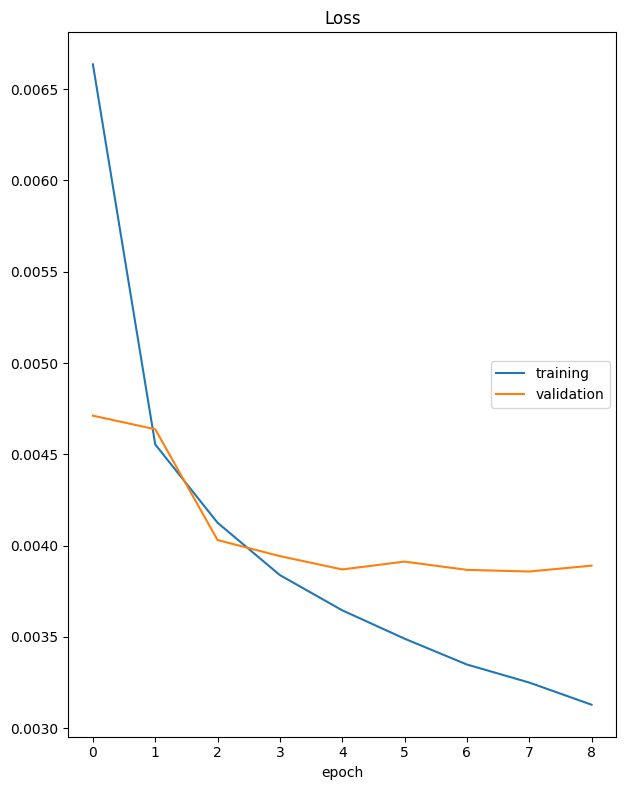

Loss
	training         	 (min:    0.003, max:    0.007, cur:    0.003)
	validation       	 (min:    0.004, max:    0.005, cur:    0.004)
Epoch 10 of 20
Train:


 77%|███████████████████████████████▌         | 298/387 [12:11<03:31,  2.38s/it]

In [ ]:
device = 'cpu'
cvae = cVAE.VAE_Conv(device).to(device)

if not os.path.exists('models/cvae.pt'):
    cvae = train(cvae, train_loader, val_loader, epochs=20, device=device)
    torch.save(cvae.state_dict(), 'models/cvae.pt')
else:
    cvae.load_state_dict(torch.load('models/cvae.pt'))

### Plot validation results (actual vs forecasted):

In [ ]:
images, labels = next(iter(train_loader))
cvae.eval()

fig, ax = plt.subplots(2, 5, figsize=[18.5, 6])
fig.tight_layout(pad=4)
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
    recon, _ = cvae(images[idx].unsqueeze(0)) 
    ax[0, n].imshow(labels[idx].squeeze())
    ax[0, n].axis('off')
    ax[1, n].imshow(recon.cpu().detach().squeeze())
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Val) Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('(Val) Forecasted:', fontsize=20, pad=20, loc='left')

### Plot test results (actual vs forecasted):

In [ ]:
test_path = 'data/Ferguson_fire_obs.npy'
test_data = np.array(np.load(open(test_path,'rb')))
test_data_shifted = torch.Tensor(test_data[1:])
test_data = torch.Tensor(test_data[:-1])
test_dataset = TensorDataset(test_data,test_data_shifted)

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[18.5, 6])
fig.tight_layout(pad=4)
mses = []
for n,(image,label) in enumerate(test_dataset):
    recon, _ = cvae(image.unsqueeze(0)) 
    mses.append(mean_squared_error(label.flatten(),recon.cpu().detach().squeeze().flatten()))
    ax[0, n].axis('off')
    ax[0, n].imshow(label.squeeze())
    ax[1, n].imshow(recon.cpu().detach().squeeze())
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Test) Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('(Test) Forecasted:', fontsize=20, pad=20, loc='left')

### MSE test:

In [ ]:
print(f'(Test) MSE: {sum(mses)/len(test_dataset)}')